# Project: Decision Trees

## Importing modules

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import ipywidgets
import random
import time
import scipy
import datetime as dt
from dateutil.relativedelta import relativedelta
import joblib
import os


from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


from imblearn.pipeline import Pipeline
from xgboost import XGBRegressor

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble

np.random.seed(3123) # impose random seed for reproducibility

[MLENS] backend: threading


In [2]:
# Getting folder location
fl = os.getcwd()
print(fl)

# Locating data
dl = os.path.join(os.getcwd(),'raw_data')
print(dl)

/home/dante/CML/computational_machine_learning_1/XGBoost
/home/dante/CML/computational_machine_learning_1/XGBoost/raw_data


# Data ingestion


In [3]:
# Loading training data
training = pd.read_csv(os.path.join(dl,'mimic_train.csv'))

# Loading test data
test = pd.read_csv(os.path.join(dl,'mimic_test_death.csv'))

# Loading comorbidities data
comorbidities = pd.read_csv(os.path.join(dl,'MIMIC_diagnoses.csv'))

In [4]:
# Checking variables available
print(training.columns)
print(test.columns)
print(comorbidities.columns)

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS'],
      dtype='object')
Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean',

# Average lengt of stay sum - metric implementation
The avg_LOS_sum will be based on the following intuition.

a) having a certain ICD9 diagnosis has a potential impact on the Length of Stay in the ICU (LOS) for a given patient.

b) having multiple ICD9 diagnoses has an arguably larger impact on the LOS for a given patient.

To construct an index that takes this into account, I will perform the feature engineering/manipulation:

1. Calculate the average LOS per co-morbidity.

2. Group sum the average LOS per co-morbidity by hospitalization ID.

3. Join this to the test and training data. Call this <font color='green'> avg_LOS_sum</font>.

In essence, this should account for the 'additive strain' nature of having multiple ICD9 diagnoses at the same time.


In [5]:
training.head(5)

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [6]:
test.head(5)

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,...,2196-02-23 11:45:00,-67454.42740,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...,4241,CSRU
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,...,2103-10-22 23:58:00,-34204.08546,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,HYPERGLYCEMIA,25013,MICU
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,...,2115-06-28 07:15:00,-38710.61714,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,KIDNEY STONES/SDA,5920,MICU
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,...,2162-08-01 21:00:00,-54902.54313,EMERGENCY,Private,EPISCOPALIAN,WIDOWED,WHITE,RIGHT FEMUR FRACTURE,82120,CCU
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,...,2103-01-16 22:05:00,-33906.93488,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,PNEUMONIA;RAPID AF;HYPOXIA,51884,MICU


In [7]:
comorbidities.head(5)

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [8]:
# Creating a copy of the comorbidity dataframe
comorb_copy = comorbidities.copy()

# Renaming columns for easier data manipulation
comorb_copy.rename(columns = {'HADM_ID' : 'hadm_id','SUBJECT_ID' : 'subject_id'},inplace=True)

# Dropping sequence number (i.e. which disease diagnosis the ICD9_CODE corresponds to for a given hospital admission)
comorb_copy.drop(['SEQ_NUM'],1,inplace=True)

/tmp/ipykernel_24792/2015344326.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  comorb_copy.drop(['SEQ_NUM'],1,inplace=True)


In [9]:
# Creating a dataframe that only contains training hospitalization admission id
# and the length of stay for that hospital admission id. We will merge this info
# to the comorbidities to calculate average LOS for each ICD9_code in comorbidities.
di_df = training[['hadm_id','LOS']]
print(comorb_copy.head())
print(di_df.head())

   subject_id  hadm_id ICD9_CODE
0         256   108811     53240
1         256   108811     41071
2         256   108811     53560
3         256   108811     40390
4         256   108811      5859
   hadm_id     LOS
0   195768  4.5761
1   126136  0.7582
2   136645  3.7626
3   102505  3.8734
4   127337  5.8654


In [10]:
# Here, we want to explode the data so that each hadm_id x icd9_code 
# combination is present in the dataset.
di_df_merged=di_df.merge(comorb_copy[['hadm_id','ICD9_CODE']],how='left',on='hadm_id')

# Inspecting..
di_df_merged.head(5)

,hadm_id,LOS,ICD9_CODE
0,195768,4.5761,5789
1,195768,4.5761,51881
2,195768,4.5761,41071
3,195768,4.5761,42831
4,195768,4.5761,42732


In [11]:
# What we want to do next is calculate the average LOS by ICD9_CODE...
d_tot = di_df_merged.groupby('ICD9_CODE').agg({'LOS':'mean'})

In [12]:
d_tot = d_tot.sort_values(axis=0, by='LOS',ascending=False)

# Consequently, we end up with the sum of LOS by ICD_9 code.
d_tot.head(5)

,LOS
ICD9_CODE,
9580,101.7390
1463,63.4533
63491,61.9167
67403,61.9167
64203,61.9167


In [13]:
# Renaming columns to reflect what we've done so far
d_tot.rename(columns={'LOS' : 'avg_LOS'},inplace=True)

# Casting as string
d_tot['ICD9_CODE'] = d_tot.index.astype('str')

# Resetting index 
d_tot = d_tot.reset_index(drop=True)

# Inspecting work so far..
d_tot.head()

,avg_LOS,ICD9_CODE
0,101.7390,9580
1,63.4533,1463
2,61.9167,63491
3,61.9167,67403
4,61.9167,64203


In [14]:
comorbidities.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [15]:
# Here, we spread out the avg_LOS to the comorbidities data, and sum by hadm_id...
comorbidities_merged=comorbidities.merge(d_tot[['ICD9_CODE','avg_LOS']],how='left',on='ICD9_CODE')

# Dropping unnecessary columns...
comorbidities_merged.drop(['SEQ_NUM'],1,inplace=True)

# Inspecting..
comorbidities_merged.head()

/tmp/ipykernel_24792/2689733985.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  comorbidities_merged.drop(['SEQ_NUM'],1,inplace=True)


,SUBJECT_ID,HADM_ID,ICD9_CODE,avg_LOS
0,256,108811,53240,4.263924
1,256,108811,41071,4.499102
2,256,108811,53560,2.736041
3,256,108811,40390,3.857329
4,256,108811,5859,3.895319


In [16]:
# Creating disease count variable (will be summed up by hadm_id)
comorbidities_merged['disease_count'] = 1

# Summing/meaning up variables by hadm_id, for matching with training and test data purposes...
d = {'avg_LOS':'avg_LOS_sum'}
los_indexes=comorbidities_merged.groupby('HADM_ID').agg({'avg_LOS':'sum','disease_count':'sum'}).rename(columns=d)

# Inspecting...
los_indexes.head()

,avg_LOS_sum,disease_count
HADM_ID,,
100001,55.567898,16
100003,35.696968,9
100006,42.188622,9
100007,31.335467,5
100009,63.940397,18


In [17]:
# Creating a new column for the hadm_id..
los_indexes['hadm_id'] = los_indexes.index.astype('str')

count    58976.000000
mean        46.907785
std         35.339772
min          0.000000
25%         22.285436
50%         40.086170
75%         64.262579
max        391.329149
Name: avg_LOS_sum, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6efe828730>]],
      dtype=object)

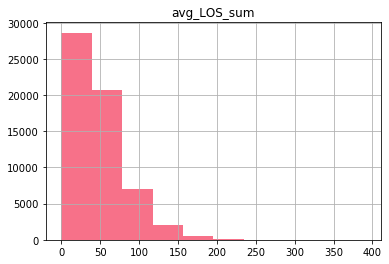

In [18]:
# Looking at the distribution of avg_LOS_sum across the comorbidities set.. 
# Seems like there is meaningful variation in the data!!!
print(los_indexes.avg_LOS_sum.describe())
los_indexes.hist(column='avg_LOS_sum')

In [19]:
los_indexes.head()

,avg_LOS_sum,disease_count,hadm_id
HADM_ID,,,
100001,55.567898,16,100001
100003,35.696968,9,100003
100006,42.188622,9,100006
100007,31.335467,5,100007
100009,63.940397,18,100009


In [20]:
# Resetting index
los_indexes.reset_index(inplace=True, drop = True)
los_indexes['hadm_id'] = los_indexes['hadm_id'].astype('int')

## Migrating disease count and avg_LOS_sum to training data

In [21]:
# Defining variables we want to merge
mergelist = ['hadm_id','disease_count','avg_LOS_sum']

# Merging them
training.rename(columns = {'ICD9_diagnosis' : 'ICD9_CODE'}, inplace = True)
training_merged=training.merge(los_indexes[mergelist],how='left',on='hadm_id')

# Inspecting result
training_merged.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_CODE,FIRST_CAREUNIT,LOS,disease_count,avg_LOS_sum
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761,17,73.770483
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582,3,9.283488
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626,14,70.330355
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734,15,60.433065
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654,16,91.382473


## Migrating disease count and avg_LOS_sum to training data

In [22]:
# Merging to test data
test.rename(columns = {'ICD9_diagnosis' : 'ICD9_CODE'}, inplace = True) 
test_merged=test.merge(los_indexes[mergelist],how='left',on='hadm_id')

# Inspecting result
test_merged.head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_CODE,FIRST_CAREUNIT,disease_count,avg_LOS_sum
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,...,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...,4241,CSRU,20,81.151600
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,...,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,HYPERGLYCEMIA,25013,MICU,11,69.472542
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,...,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,KIDNEY STONES/SDA,5920,MICU,12,61.872560
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,...,EMERGENCY,Private,EPISCOPALIAN,WIDOWED,WHITE,RIGHT FEMUR FRACTURE,82120,CCU,16,66.723293
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,...,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,PNEUMONIA;RAPID AF;HYPOXIA,51884,MICU,29,136.973273


# Other feature engineering

In [23]:
# Creating columns for whether a patient has been in the hospital and or the ICU before in the training data.
training_merged['icu_again'] = np.where(training_merged.duplicated(subset=['subject_id', 'hadm_id']),1,0)
training_merged['hospital_again'] = np.where(training_merged.duplicated(subset=['subject_id']),1,0)

In [24]:
# Creating columns for whether a patient has been in the hospital and or the ICU before in the test data.
test_merged['icu_again'] = np.where(test_merged.duplicated(subset=['subject_id', 'hadm_id']),1,0)
test_merged['hospital_again'] = np.where(test_merged.duplicated(subset=['subject_id']),1,0)

In [25]:
# We see that there is a significant number of people in that appear several times in the ICU.
# These people ought to be in worse shape -> could increase or decrease LOS...
training_merged.icu_again.value_counts()

0    19749
1     1136
Name: icu_again, dtype: int64

In [26]:
# We see that there is a significant number of people in that appear several times in the ICU.
# These people ought to be in worse shape -> could increase or decrease LOS...
test_merged.icu_again.value_counts()

0    5161
1      60
Name: icu_again, dtype: int64

In [27]:
# Renaming
training = training_merged.copy()

# Renaming
test = test_merged.copy()

In [28]:
# Computing age & other variables (can't use a simple difference as this leads to overflow error...)
training['ADMITTIME'] = pd.to_datetime(training['ADMITTIME'])
training['DOB'] = pd.to_datetime(training['DOB'])
training['age'] = [relativedelta(a, b).years for a, b in zip(training['ADMITTIME'], training['DOB'])]
training['admit_year'] = pd.DatetimeIndex(training['ADMITTIME']).year
training['admit_month'] = pd.DatetimeIndex(training['ADMITTIME']).month
training['admit_hour'] = pd.DatetimeIndex(training['ADMITTIME']).hour

In [29]:
# Dropping all irrelevant columns (both out of project prompt and found through tinkering)
training.drop(['hadm_id','subject_id'],1,inplace=True)
training.drop(['icustay_id','DOB','ADMITTIME','Diff','DIAGNOSIS'],1,inplace=True)
# training.drop(['MARITAL_STATUS'],1,inplace=True)
training.drop(['HOSPITAL_EXPIRE_FLAG'],1,inplace=True)
training.drop(['ICD9_CODE'],1,inplace=True)

In [30]:
# Computing age & other variables (can't use a simple difference as this leads to overflow error...)
test['ADMITTIME'] = pd.to_datetime(test['ADMITTIME'])
test['DOB'] = pd.to_datetime(test['DOB'])
test['age'] = [relativedelta(a, b).years for a, b in zip(test['ADMITTIME'], test['DOB'])]
test['admit_year'] = pd.DatetimeIndex(test['ADMITTIME']).year
test['admit_month'] = pd.DatetimeIndex(test['ADMITTIME']).month
test['admit_hour'] = pd.DatetimeIndex(test['ADMITTIME']).hour

In [31]:
# Dropping all irrelevant columns (both out of project prompt and found through tinkering)
test.drop(['DOB','ADMITTIME','Diff','DIAGNOSIS'],1,inplace=True)
test.drop(['hadm_id'],1,inplace=True)
# test.drop(['MARITAL_STATUS'],1,inplace=True)
# test.drop(['RELIGION'],1,inplace=True)
test.drop(['ICD9_CODE'],1,inplace=True)

test_for_processing = test.drop(['icustay_id'],1)

In [32]:
test_for_processing.columns

Index(['subject_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
       'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER',
       'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT', 'disease_count', 'avg_LOS_sum',
       'icu_again', 'hospital_again', 'age', 'admit_year', 'admit_month',
       'admit_hour'],
      dtype='object')

In [33]:
training.columns

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOD', 'DISCHTIME', 'DEATHTIME',
       'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT', 'LOS', 'disease_count', 'avg_LOS_sum',
       'icu_again', 'hospital_again', 'age', 'admit_year', 'admit_month',
       'admit_hour'],
      dtype='object')

In [34]:
# Final look before prediction work..
training.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,FIRST_CAREUNIT,LOS,disease_count,avg_LOS_sum,icu_again,hospital_again,age,admit_year,admit_month,admit_hour
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,MICU,4.5761,17,73.770483,0,0,69,2178,2,10
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,MICU,0.7582,3,9.283488,0,0,42,2129,2,22
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,MICU,3.7626,14,70.330355,0,0,68,2125,11,23
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,SICU,3.8734,15,60.433065,0,0,74,2131,1,8
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,TSICU,5.8654,16,91.382473,0,0,79,2146,5,2


In [35]:
# Final look before prediction work..
test.head()

,subject_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,...,ETHNICITY,FIRST_CAREUNIT,disease_count,avg_LOS_sum,icu_again,hospital_again,age,admit_year,admit_month,admit_hour
0,64058,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,77.0,...,WHITE,CSRU,20,81.151600,0,0,81,2196,2,11
1,55871,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,86.0,...,WHITE,MICU,11,69.472542,0,0,48,2103,10,23
2,42892,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,76.0,...,WHITE,MICU,12,61.872560,0,0,42,2115,6,7
3,66629,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,99.0,...,WHITE,CCU,16,66.723293,0,0,84,2162,8,21
4,79851,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,133.0,...,WHITE,MICU,29,136.973273,0,0,52,2103,1,22


In [36]:
numericals = [
              'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
              'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max',
              'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
              'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'disease_count',
              'avg_LOS_sum', 'icu_again', 'hospital_again', 'age', 'admit_year', 'admit_month', 'admit_hour'
]

categoricals = [
                'GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT'
]

# Pipeline construction and Model Fitting

## Vanilla XGBRegressor pipeline

### Description of pipeline
In the vanilla XGBRegressor pipeline, the following steps are taken:

1) Using sklearn's ColumnTransformer, I transform columns separately based on whether they are numerical or categorical. Please see the above 'numericals' and 'categoricals' lists for a full description of the split of the data columns. In particular:
- **Columns of the numerical type** are simply scaled using sklearn's StandardScaler - NaN values are not processed separately using any imputer, as I am choosing to pass them to the final model as is. This is because I can thus avoid making any assumptions as to how the missing data came to be - the XGBRegressor model can take NaN's as input, and will then fit using the NaN's as information.
- **Columns of the categorical type** are made into dummies using sklearn's OneHotEncoder - again,  NaN values are not processed separately using any technique, for the same reason as above. Notice that there is a positive probability that when the GridSeachCV is splitting the data into the cross-validation folds, categories in the categorical columns do not match between the test and training set. As such, to avoid producing an error when running the pipeline, I set the __handle_unknown__ option in the OneHotEncoder to equal "<font color = 'red'>ignore</font>", which sets the value of such categorical columns to zero in the set where the column doesn't exist.

2) The pre-processed data from the ColumnTransformer is then passed to the XGBRegressor model for fitting/predicting.

In [37]:
model = XGBRegressor()
num_trans = Pipeline(steps=[("scaler", StandardScaler())])
cat_trans = OneHotEncoder(handle_unknown = "ignore")

preprocessor = ColumnTransformer(
    transformers=[
                  ("numericals", num_trans, numericals),
                  ("categoricals", cat_trans, categoricals)
])

pipeline = Pipeline(steps=[('transformer', preprocessor),
                           ('xgb',model)
                          ]
                    )

### Parameter grid definition
In the vanilla XGBRegressor pipeline, I am choosing to GridSearch over the following parameters of the XGBRegressor model (primarily because these are the ones I understand):

1) n_estimators – Number of gradient boosted trees. Equivalent to number of boosting rounds.

2) learning_rate – Boosting learning rate (xgb’s “eta”).

3) max_depth – Maximum tree depth for base learners.

In [38]:
# N.B!!!

# In the code cell below, you can see that I am not using gridsearching to search for optimal parameters,
# in the sense that my parameter grid only contains unique values for each parameter
# instead of a list. Rather, I am just using it to essentially fit and predict using the pipeline. 

# The reason behind this is simple - I ran extensive gridsearching over the grid that you can find below,
# with the best parameters coming out as the ones you can see in the code cell below! (in the sense that
# they performed best based on cross-validated scores). This was done so that I could save time when submitting
# my notebook, because I don't have 20h of time to wait for the notebook to do the same gridsearch again :) 

# Here is the set of parameters that I used for the extensive gridsearching:

# parameters = {'xgb__objective':['reg:squarederror'],
#               'xgb__learning_rate': [0.03,0.05,0.07], #so called `eta` value
#               'xgb__max_depth': [3,4,5,6,7,8,9,10],
#               'xgb__n_estimators': [450],
#               'xgb__random_state' : [43]}

# For the parameters that were chosen to be included in the grid above, I chose them in the neighborhood of
# the default values, because the default values of the XGBRegressor model are already highly optimized.

# Please also note that as for xgb__n_estimators, the larger the value, the better the algorithm will perform.
# Therefore, I am choosing to fix it at 450, which is due to the fact that the higher you make the number of 
# estimators, the higher the computational cost will be. Additionally, the returns from further increasing 
# the number of estimators diminish, while the computational time increases a lot. In my case, I judged 
# that 450 yields good enough performance without being prohibitively expensive to run.

In [39]:
parameters = {'xgb__objective':['reg:squarederror'],
              'xgb__learning_rate': [0.03], #so called `eta` value
              'xgb__max_depth': [6],
              'xgb__n_estimators': [450],
              'xgb__random_state' : [43]} 

In [40]:
# Defining the vanilla XGBRegressor grid (with cherry-picked parameter values from the extensive parameter grid two cells up)
vanilla_grid = GridSearchCV(pipeline, parameters, n_jobs=-1, 
                   cv=5,
                   scoring='neg_root_mean_squared_error',
                   verbose=10, refit=True, error_score = "raise")

In [60]:
# Fitting model
vanilla_grid.fit(training.drop(columns=['LOS'],axis=1),training['LOS'])

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numericals',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['HeartRate_Min',
                                                                          'HeartRate_Max',
                                                                          'HeartRate_Mean',
                                                                          'SysBP_Min',
                                                                          'SysBP_Max',
                                                                          'SysBP_Mean',
                                                                       

## Bagging XGBRegressor pipeline

### Description of pipeline
In the Bagging XGBRegressor pipeline, the following steps are taken:

1) Using sklearn's ColumnTransformer, I transform columns separately based on whether they are numerical or categorical. Please see the above 'numericals' and 'categoricals' lists for a full description of the split of the data columns. In particular:
- **Columns of the numerical type** are simply scaled using sklearn's StandardScaler - NaN values are not processed separately using any imputer, as I am choosing to pass them to the final model as is. This is because I can thus avoid making any assumptions as to how the missing data came to be - the XGBRegressor model can take NaN's as input, and will then fit using the NaN's as information.
- **Columns of the categorical type** are made into dummies using sklearn's OneHotEncoder - again,  NaN values are not processed separately using any technique, for the same reason as above. Notice that there is a positive probability that when the GridSeachCV is splitting the data into the cross-validation folds, categories in the categorical columns do not match between the test and training set. As such, to avoid producing an error when running the pipeline, I set the handle_unknown option in the OneHotEncoder to equal "<font color = 'red'>ignore</font>", which sets the value of such categorical columns to zero in the set where the column doesn't exist. 

2) The pre-processed data from the ColumnTransformer is then passed to sklearn's BaggingRegressor model for fitting/predicting. Please note that I am passing the best-performing XGBRegressor setup from the extensive gridsearching in part 3.1.2 as the base estimator to the BaggingRegressor. This is so that in case we have an overfitting situation, the bagging should eliminate that and consequently improve performance.

In [ ]:
# Taking best parameters from previous optimization to save on time
xgb_best_params= {'learning_rate' : vanilla_grid.best_params_['xgb__learning_rate'],
                   'max_depth' : vanilla_grid.best_params_['xgb__max_depth'],
                   'n_estimators' : vanilla_grid.best_params_['xgb__n_estimators'],
                   'objective' : vanilla_grid.best_params_['xgb__objective'],
                   'random_state' : vanilla_grid.best_params_['xgb__random_state']}


# Defining a new model, now with the best parameters.
xgb_best = XGBRegressor(**xgb_best_params)
model2 = BaggingRegressor(base_estimator=xgb_best)

# Making a transformer for both the numerical columns and 
# categorical columns
num_trans = Pipeline(steps=[("scaler", StandardScaler())])
cat_trans = OneHotEncoder(handle_unknown = "ignore")

# Placing them in a pre-processor (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
                  ("numericals", num_trans, numericals),
                  ("categoricals", cat_trans, categoricals)
])

# Defining final pipeline
pipeline2 = Pipeline(steps=[('transformer', preprocessor),
                           ('bagr',model2)
                          ]
                    )

### Parameter grid definition
In the Bagging XGBRegressor pipeline, I am choosing to GridSearch over the following parameters of the BaggingRegressor (primarily because these are the ones I understand):

1) bootstrap – Whether samples are drawn with replacement. If False, sampling without replacement is performed.

2) bootstrap_features – Whether features are drawn with replacement.

3) n_estimators – The number of base estimators in the ensemble.

4) max_samples - The number of samples to draw from X to train each base estimator.

5) base_estimator__objective - Specify the learning task and the corresponding learning objective (in our case, it is 'reg:squarederror') for the XGBRegressor that is used as the base estimator of the BaggingRegressor. Please note that this parameter along with the two below are all specific to the XGBRegressor, and would be different should we choose to use a different base estimator, for example DecisionTreeRegressor (which is the default base learner of the BaggingRegressor). <font color ='red'>NOT USED IN FINAL</font>

6) base_estimator__learning_rate - Boosting learning rate (xgb’s “eta”). <font color ='red'>NOT USED IN FINAL</font>

7) base_estimator__n_estimators - Number of gradient boosted trees in the base estimator of the BaggingRegressor Model. Generally, the larger the better for predictive performance, but computational cost will also increase, creating a trade-off. <font color ='red'>NOT USED IN FINAL</font>

8) base_estimator__max_depth - Maximum tree depth for the base estimator. <font color ='red'>NOT USED IN FINAL</font>

In [ ]:
# N.B!!!

# In the code cell below, you can see that I am not using gridsearching to search for optimal parameters,
# in the sense that my parameter grid only contains unique values for each parameter
# instead of a list. Rather, I am just using it to essentially fit and predict using the pipeline.

# The reason behind this is simple - I ran extensive gridsearching over the grid that you can find below,
# with the best parameters coming out as the ones you can see in the code cell below! (in the sense that
# they performed best based on cross-validated scores). This was done so that I could save time when submitting
# my notebook, because I don't have 20h of time to wait for the notebook to do the same gridsearch again :) 

# Here is the set of parameters that I used for the extensive gridsearching:

# parameters2 = {
#  'bagr__bootstrap': [True, False],
#  'bagr__bootstrap_features': [True, False],    
#  'bagr__n_estimators': [10,15,20,25,30],
#  'bagr__max_samples' : [0.6, 0.8, 1.0],
#  # 'base_estimator__objective': ['reg:squarederror'], (not used in final)   
#  # 'base_estimator__learning_rate': [0.03,0.05,0.07], (not used in final)
#  # 'base_estimator__max_depth' : [3,4,5,6,7,8,9,10], (not used in final)
#  # 'base_estimator__n_estimators' : [450] (not used in final)
# }

In [51]:
parameters2 = {
 'bagr__bootstrap': [True],
 'bagr__bootstrap_features': [False],    
 'bagr__n_estimators': [30],
 'bagr__max_samples' : [1.0]
#  'base_estimator__objective': ['reg:squarederror'],    
#  'base_estimator__learning_rate': [0.03,0.05,0.07],
#  'base_estimator__max_depth' : [3,4,5,6,7,8,9,10],
#  'barg__base_estimator__n_estimators' : [450]
}

In [52]:
# Defining the BaggingRegressor grid (with cherry-picked parameter values from the extensive parameter grid two cells up)
bagging_grid = GridSearchCV(pipeline2, parameters2, n_jobs=-1, 
                   cv=5,
                   scoring='neg_root_mean_squared_error',
                   verbose=10, refit=True, error_score = "raise")
bagging_grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__transformer', 'estimator__bagr', 'estimator__transformer__n_jobs', 'estimator__transformer__remainder', 'estimator__transformer__sparse_threshold', 'estimator__transformer__transformer_weights', 'estimator__transformer__transformers', 'estimator__transformer__verbose', 'estimator__transformer__verbose_feature_names_out', 'estimator__transformer__numericals', 'estimator__transformer__categoricals', 'estimator__transformer__numericals__memory', 'estimator__transformer__numericals__steps', 'estimator__transformer__numericals__verbose', 'estimator__transformer__numericals__scaler', 'estimator__transformer__numericals__scaler__copy', 'estimator__transformer__numericals__scaler__with_mean', 'estimator__transformer__numericals__scaler__with_std', 'estimator__transformer__categoricals__categories', 'estimator__transformer__categoricals__drop', 'estimator__transformer__categoricals__dtype'

In [ ]:
# Fitting model
bagging_grid.fit(training.drop(columns=['LOS'],axis=1),training['LOS'])

# Prediction and model evaluation

In [53]:
# Performance reporting function
def performance(model, model_name):
    print(model_name)
    print('Best Score: ' + str(-1*model.best_score_))
    print('Best Parameters: ' + str(model.best_params_))

In [ ]:
# Predicting LOS with Vanilla gridsearch/pipeline
yhat_vanilla = vanilla_grid.best_estimator_.predict(test_for_processing.drop(['subject_id'],1))

# Predicting LOS with Bagging gridsearch/pipeline
yhat_bagging = bagging_grid.best_estimator_.predict(test_for_processing.drop(['subject_id'],1))

In [ ]:
model_dict = {'vanilla' : vanilla_grid, 'bagging' : bagging_grid}

In [ ]:
for key in model_dict.keys():
  performance(model_dict[key],str(key))

vanilla
Best Score: 3.844245450751205
Best Parameters: {'xgb__learning_rate': 0.03, 'xgb__max_depth': 6, 'xgb__n_estimators': 450, 'xgb__objective': 'reg:squarederror', 'xgb__random_state': 43}
bagging
Best Score: 3.874845349014471
Best Parameters: {'bagr__n_estimators': 30}


## Discussion
- From the above results, we can seen that the cross-validated root mean squared error is lower for the 'vanilla' XGBRegressor model than for Bagged version. 

- As such, it yields some evidence of the fact that the optimized version of the XGBRegressor model is not overfitting the data.

- Therefore, I have chosen to use the 'vanilla' XGBRegressor model predictions as the final submission in the Kaggle competition.

In [ ]:
# Taking our predictions and putting them in a list for final format...
empty_list = []
for observation in yhat_vanilla:
  empty_list.append(observation)

final_pred = np.array(empty_list)

In [ ]:
# Saving the final submission to Gdrive, for uploading...
final_data = {'icustay_id': test.icustay_id, 'LOS': final_pred}
submission = pd.DataFrame(data=final_data)
submission.to_csv(os.path.join(fl,'processed_data/predicted_deaths.csv'), index =False)